# Facial Landmark Classification 

This notebook extract/loads the facial landmarks from the video files and fit the model for these data. 

In [1]:
# Importing Necessary Functions/Packages
from glob import glob
import os 
import shutil
import tensorflow as tf
import numpy as np 
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
# Custom Functions
from john_romero_video_functions import *

In [2]:
# Loading the Visual Directories 
vis_data_dir, full_vis_data, vis_raw_dir, vis_proc_dir, lmrk_dir, fig_dir, model_dir = get_vis_dirs()

In [3]:
# Getting Raw Video Only Files into a separate directory 
fnames = glob(os.path.join(full_vis_data, '*', '*', '*', '02*.mp4'))
for f in fnames: 
    actor, basename = f.split('\\')[-2:]
    actor_dir = os.path.join(vis_raw_dir, actor)
    if not os.path.isdir(actor_dir): os.mkdir(actor_dir)
    shutil.move(f, os.path.join(actor_dir, basename))

In [7]:
# Getting the landmark datasets for the partitions
train = get_landmark_dataset('train')
val = get_landmark_dataset('val')
test = get_landmark_dataset('test')

# Separating the information from each partition 
train_fn, train_tar, train_feats = zip(*train)
val_fn, val_tar, val_feats = zip(*val)
test_fn, test_tar, test_feats = zip(*test)

# Normalizing the Landmark datasets
train_norm = normalize_landmark_ds(train_feats)
val_norm = normalize_landmark_ds(val_feats)
test_norm = normalize_landmark_ds(test_feats)

# Gathering the datasets information into TF Tensors 
train_tar_oh, train_feats = tf.stack(train_tar), tf.ragged.stack(train_norm)
val_tar_oh, val_feats = tf.stack(val_tar), tf.ragged.stack(val_norm)
test_tar_oh, test_feats = tf.stack(test_tar), tf.ragged.stack(test_norm)

In [9]:
# Fit Normalization Layer using the training data
model = tf.keras.models.Sequential(name='VisFeatModel', 
                                   layers=[  
    
    # Input Layer (Specifies the number of features)                                   
    tf.keras.layers.Input(shape = [None, 136]), 


    # Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, return_state=False,
                             dropout=0.3, recurrent_dropout=0.2)
        , name='BiLSTM1'
    ),

    # Bi-LSTM Layer                    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, return_state=False, 
                             dropout=0.3, recurrent_dropout=0.2), name='BiLSTM2'
    ), 
                                       
    # Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=False, return_state=False,
                             dropout=0.3, recurrent_dropout=0.2), name='BiLSTM3'
    ),
                                       
    # Output Layer
    tf.keras.layers.Dense(7, activation='softmax', name='Softmax')
])


In [10]:
# Batch Size
batch_size = 56

# Compile the Model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Display Details
model.summary()

Model: "VisFeatModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BiLSTM1 (Bidirectional)     (None, None, 256)         271360    
                                                                 
 BiLSTM2 (Bidirectional)     (None, None, 256)         394240    
                                                                 
 BiLSTM3 (Bidirectional)     (None, 128)               164352    
                                                                 
 Softmax (Dense)             (None, 7)                 903       
                                                                 
Total params: 830,855
Trainable params: 830,855
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Specify the Model File Name
model_fname = os.path.join(model_dir, f'video_bilstm_landmark_model.h5')

# Callback to Save Model with Minimum Val Loss
callback_list = [
       tf.keras.callbacks.ModelCheckpoint(
           filepath= model_fname, 
           verbose=1, save_freq='epoch', 
           monitor='val_loss', save_best_only=True, mode='min'
       )         
]

# Fit the Facial Landmark Classification Model
history = model.fit(x = train_feats, y = train_tar_oh, 
                    batch_size=batch_size,
                    validation_data = (val_feats, val_tar_oh),
                    shuffle=True,
                    callbacks = callback_list,
                    epochs=30, 
                    verbose=1) 

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 1.9076 - accuracy: 0.2242
Epoch 1: val_loss improved from inf to 1.84559, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\video_bilstm_landmark_model.h5
18/18 [==============================] - 56s 3s/step - loss: 1.9076 - accuracy: 0.2242 - val_loss: 1.8456 - val_accuracy: 0.2546
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 1.8011 - accuracy: 0.3145
Epoch 2: val_loss improved from 1.84559 to 1.79036, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\video_bilstm_landmark_model.h5
18/18 [==============================] - 38s 2s/step - loss: 1.8011 - accuracy: 0.3145 - val_loss: 1.7904 - val_accuracy: 0.3056
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 1.7351 - accuracy: 0.3462
Epoch 3: val_loss improved from 1.79036 to 1.74936, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\video_bilstm_landmark_model.h5
18/18 [====

In [3]:
# Training Loss Plot File Name 
train_loss_fn = os.path.join(fig_dir, f'training_loss_video_landmarks.png')
train_acc_fn = os.path.join(fig_dir, f'training_acc_video_landmarks.png')

# Plot the Training Curves
plot_history(history, 
            loss_fn = train_loss_fn, 
            acc_fn = train_acc_fn, 
            loss_title = f'Training Loss: Video Landmarks', 
            acc_title = f'Training Accuracy: Video Landmarks') 

NameError: name 'fig_dir' is not defined

In [2]:
# Restating Model FName in case it is not being retrained 
model_fname = os.path.join(model_dir, f'video_bilstm_landmark_model.h5')

# Reloading the best model 
best_model = tf.keras.models.load_model(filepath = model_fname)

# Gathering Test Set Prediction Categories
test_preds = best_model.predict(test_feats)
test_preds = np.argmax(test_preds, axis=1, keepdims = True)
test_preds = tf.keras.utils.to_categorical(test_preds).astype(np.int64).tolist()

# One-Hot Encoding Predictions and True Values
pred = [inv_label(pred) for pred in test_preds]
true = [inv_label(lab) for lab in test_tar_oh.numpy().astype(np.int64).tolist()]

NameError: name 'model_dir' is not defined

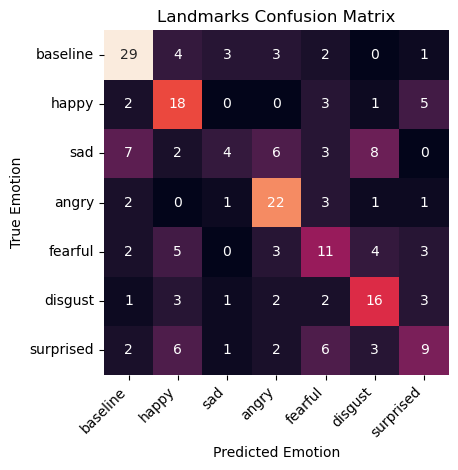

In [14]:
# Test Confusion Matrix File Name
cm_fname = os.path.join(fig_dir, f'test_cm_landmarks.png')

categories = ['baseline', 'happy', 'sad', 'angry',
             'fearful', 'disgust','surprised']

cm = confusion_matrix(y_true = true, y_pred = pred, labels=categories)
fig, ax = plt.subplots()

plt.title(f'Landmarks Confusion Matrix')
sns.heatmap(cm, ax=ax, annot=True, cbar=False, square=True)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.savefig(cm_fname)
plt.show()

In [15]:
# Showing Classification Report for Test Set
print(f'Testing Set Accuracy: {accuracy_score(true, pred)}')
print(classification_report(y_true=true, y_pred=pred))

Testing Set Accuracy: 0.5046296296296297
              precision    recall  f1-score   support

       angry       0.58      0.73      0.65        30
    baseline       0.64      0.69      0.67        42
     disgust       0.48      0.57      0.52        28
     fearful       0.37      0.39      0.38        28
       happy       0.47      0.62      0.54        29
         sad       0.40      0.13      0.20        30
   surprised       0.41      0.31      0.35        29

    accuracy                           0.50       216
   macro avg       0.48      0.49      0.47       216
weighted avg       0.49      0.50      0.48       216

